# An Exploratory Data Analysis (EDA) on Dota 2

 ### Preparing the dataset for further analysation
Since all data is fetched from opendota, there is no cleaning required

In [1]:
import numpy as np
import os.path
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from time import sleep

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
'''

import seaborn as seabornInstance 
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
'''

'\n\nimport seaborn as seabornInstance \nimport re\nfrom sklearn.preprocessing import OneHotEncoder\nfrom sklearn import preprocessing\nfrom sklearn.model_selection import cross_val_predict\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.linear_model import Ridge\nimport statsmodels.api as sm\nfrom sklearn.model_selection import train_test_split \nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\nfrom sklearn import metrics\n%matplotlib inline\n'

In [3]:
base_path     = os.path.abspath('')
data_folder  = base_path + "/data/"

# read dataset
df = pd.read_csv(f"{data_folder}16818057.csv") # file generated by my opendata-stats script
print(df.shape)
df.head()

(7656, 17)


,match_id,player_slot,radiant_win,hero_id,start_time,duration,game_mode,lobby_type,version,kills,deaths,assists,skill,average_rank,leaver_status,party_size,won
0,6837445810,1,False,Riki,1667330973,2012,turbo,normal,21.0,16,6,6,NaN,NaN,0,1.0,Lost
1,6836407107,0,False,Nature's Prophet,1667300262,1392,turbo,normal,NaN,6,3,2,NaN,NaN,0,1.0,Lost
2,6835404099,2,False,Nature's Prophet,1667242218,1852,turbo,normal,NaN,1,5,6,NaN,31.0,0,2.0,Lost
3,6835360185,129,True,Primal Beast,1667240772,1164,turbo,normal,NaN,1,4,7,NaN,23.0,0,2.0,Lost
4,6834493847,2,False,Marci,1667216859,1352,turbo,normal,NaN,2,5,9,NaN,NaN,0,1.0,Lost


## Check is there are columns that could be dropped

In [4]:
df.nunique()

match_id         7656
player_slot        27
radiant_win         2
hero_id           124
start_time       7656
duration         2718
game_mode          20
lobby_type          7
version             5
kills              36
deaths             24
assists            36
skill               2
average_rank       22
leaver_status       5
party_size          7
won                 2
dtype: int64

### Which are the five game modes I have not played?

In [5]:
game_mode_played = df.game_mode.unique().tolist()
with open(f"{data_folder}game_mode.txt", "r") as f: # file from my opendata-stats data folder
    all_game_modes = dict(x.rstrip().split(None, 1) for x in f)    
for entry in all_game_modes.values():
    if entry not in game_mode_played:
        print(entry)

intro
reverse_captains_mode
tutorial
mid_only
balanced_draft


I wasn't aware of the difference between some of the modes, but I found the following explanation on the Dota2 fandom wiki 
https://dota2.fandom.com/wiki/Game_modes

#### 1v1 Solo Mid
Play 1v1 against another player in the middle lane.
This mode is not available in public matchmaking. Practice your mid-lane play against another player. The first player to achieve two kills or destroy an enemy tower wins. Players can pick identical heroes, and cannot see their opponent's hero choice until they have made a selection. Only the middle lane will spawn creeps. Each player starts off with a courier, free of charge.
- First set of runes does not spawn.
- Players can voice chat with each other.
- Players may forfeit by calling 'gg' or leaving the match.
- Side towers are invulnerable.

#### Mid Only (Private Lobby)
Creeps only spawn in the middle lane. Duplicate heroes allowed.
Similar to 1v1 Solo Mid but less restrictive. Creeps only spawn in middle lane, and players are allowed to select the same hero. Any amount of players can play, and the game only ends when either team's ancient is destroyed. 

### Why are there 27 different player slots?

In [6]:
df.player_slot.unique()

array([  1,   0,   2, 129,   3, 128, 132, 131,   4, 130,   8,  22,   9,
        21,   7,  11,  19,  12,  14,  15,  18,  20,   6,  17,  13,  16,
        10], dtype=int64)

#### Which game mode using different slots?
Probably the fraction and won column are not correct for some modes.

In [7]:
df[df['player_slot'].between(6, 22)].pivot_table(index='player_slot', columns='game_mode', values='won', aggfunc='sum')

game_mode,event
player_slot,
6,LostLost
7,LostLostLostLostLost
8,LostLostLostLostLostLost
9,LostLostLostLostLost
10,Lost
11,LostLostLostLostLostLostLost
12,LostLostLostLost
13,LostLostLostLost
14,LostLost


All deviating slots result from the game mode event. 
Since I want to analyse regular matches, I will drop all rows from special game modes.

In [8]:
for game_mode in ["mutation", "1v1_mid", "custom", "greeviling", "diretide", "unknown", "event"]:
    df.drop(df[(df["game_mode"] == game_mode)].index, inplace=True)

### Why are there only five different versions?

In [9]:
df.version.unique()

array([21., nan, 20., 16., 10., 13.])

Versions do not indicate the respective patch. Unfortunately, no further information about versions is stored in the opendota API documentation.
Patches are not retrieved with the query https://api.opendota.com/api/players/{account_id}/matches. Either I have to make a new API query of the patch for each match. This may exceed the limit for the free version. Or alternatively, based on the helper files of my opendota-stats script, determine the particular patch.

In [10]:
df.drop("version", axis=1, inplace=True)

### Why are there 124 hero ids, while there are currently 123 heroes?

In [11]:
df.hero_id.unique()

array(['Riki', "Nature's Prophet", 'Primal Beast', 'Marci', 'Dawnbreaker',
       'Anti-Mage', 'Dark Willow', 'Arc Warden', 'Techies', 'Windranger',
       'Ursa', 'Tidehunter', 'Clockwerk', 'Tiny', 'Undying', 'Sven',
       'Lina', 'Sniper', 'Witch Doctor', 'Legion Commander', 'Luna',
       'Rubick', 'Leshrac', 'Lycan', 'Lone Druid', 'Bloodseeker',
       'Spirit Breaker', 'Death Prophet', 'Huskar', 'Dragon Knight',
       'Tusk', 'Snapfire', 'Medusa', 'Io', 'Weaver', 'Shadow Fiend',
       'Doom', 'Earth Spirit', 'Silencer', 'Juggernaut',
       'Templar Assassin', 'Beastmaster', 'Keeper of the Light', 'Chen',
       'Razor', 'Warlock', 'Phantom Assassin', 'Ember Spirit',
       'Bristleback', 'Lion', 'Sand King', 'Pugna', 'Mars', 'Elder Titan',
       'Zeus', 'Axe', 'Shadow Demon', 'Abaddon', 'Dazzle', 'Terrorblade',
       'Jakiro', 'Bounty Hunter', 'Mirana', 'Lich', 'Ancient Apparition',
       'Timbersaw', 'Invoker', 'Crystal Maiden', 'Pangolier',
       'Earthshaker', 'Outworld

In [12]:
df.query("hero_id == '0'")

,match_id,player_slot,radiant_win,hero_id,start_time,duration,game_mode,lobby_type,kills,deaths,assists,skill,average_rank,leaver_status,party_size,won
3400,481267830,1,False,0,1390506903,360,captains_draft,ranked,0,0,0,NaN,NaN,1,NaN,Lost
7218,300482215,129,False,0,1378485182,30,captains_mode,normal,0,0,0,NaN,NaN,1,NaN,Won


In the regular call of the two matches via the opendota website (https://www.opendota.com/matches/300482215), the hero is unknown for the most players. When called via the API (https://api.opendota.com/api/matches/300482215), the heroes are displayed.
However, since there are only two matches, they are removed.

In [13]:
df.drop(df.query("hero_id == '0'").index, inplace=True)

### Uncommon Party sizes

In [14]:
df.party_size.value_counts(dropna=False)

NaN     3979
1.0     2596
2.0      480
3.0      126
10.0       9
0.0        8
4.0        3
5.0        2
Name: party_size, dtype: int64

In [15]:
df.query("party_size == 10")

,match_id,player_slot,radiant_win,hero_id,start_time,duration,game_mode,lobby_type,kills,deaths,assists,skill,average_rank,leaver_status,party_size,won
996,5799673272,3,False,Ogre Magi,1611429848,1589,captains_mode,battle_cup,2,9,3,1.0,NaN,0,10.0,Lost
1484,5392754806,1,False,Witch Doctor,1588442567,3247,captains_mode,battle_cup,3,10,9,NaN,NaN,0,10.0,Lost
1493,5378786781,4,False,Nature's Prophet,1587837675,1967,captains_mode,battle_cup,2,10,5,1.0,NaN,0,10.0,Lost
1506,5364490777,128,True,Faceless Void,1587236773,2607,captains_mode,battle_cup,2,9,7,NaN,NaN,0,10.0,Lost
1527,5349509895,4,False,Clockwerk,1586631362,3528,captains_mode,battle_cup,3,15,18,NaN,NaN,0,10.0,Lost
5011,5799580002,131,False,Nature's Prophet,1611425342,3259,captains_mode,battle_cup,7,14,11,NaN,NaN,0,10.0,Won
5506,5364366831,128,False,Riki,1587232855,2991,captains_mode,battle_cup,7,10,23,NaN,NaN,0,10.0,Won
5519,5349432416,132,False,Slardar,1586628846,1402,captains_mode,battle_cup,4,3,7,NaN,NaN,0,10.0,Won
6235,2212487365,3,True,Slark,1457625978,3755,all_draft,ranked,44,7,19,NaN,NaN,0,10.0,Won


I assume that party_size of 0 equals unknown. Will keep 0, 10 and replace 0 and NaN entries with 1.0

In [16]:
df.party_size.replace(0.0, np.nan, inplace=True)
df.party_size.fillna(1.0, inplace=True)
df.party_size.value_counts()

1.0     6583
2.0      480
3.0      126
10.0       9
4.0        3
5.0        2
Name: party_size, dtype: int64

#### Skill Distribution

In [17]:
df.skill.value_counts(dropna=False)

NaN    4180
1.0    3022
2.0       1
Name: skill, dtype: int64

Since there is no documentation about the skill variable I decided to drop the column.

In [18]:
df.drop("skill", axis=1, inplace=True)

## Feature Engineering

### Patch Version, Region played, destroyed towers, stomp? and comebac

In [19]:
df.shape

(7203, 15)

The OpenDota API is limited to 50,000 free calls per month and 60 requests/minute.
To be safe that there are not to many request per minute, I will delay the requests by 1.5 seconds, which lead to 3 hours of time.

In [20]:
7203 * 1.5 / 60 / 60

3.0012499999999998

In [21]:
# uncomment to use, but keep in mind it takes long. You could break it down in smaller chunks and mabe add and try/except

'''
match_details = []
for match_id in df.match_id.unique().tolist():
    url = f"https://api.opendota.com/api/matches/{match_id}" 

    # start request
    resp = requests.get(url=url)
    data = resp.json()
    tmp_dict = { "match_id"                : data.get("match_id"),
                 "barracks_status_dire"    : data.get("barracks_status_dire"),
                 "barracks_status_radiant" : data.get("barracks_status_radiant"),   
                 "patch"                   : data.get("patch"),
                 "region"                  : data.get("region"),         
                 "comeback"                : data.get("comeback"),
                 "stomp"                   : data.get("stomp")}  
    sleep(1.25)
    match_details.append(tmp_dict)
len(match_details)
df = pd.DataFrame.from_records(match_details)
df.to_csv(f"{data_folder}matchdetails.csv", index=False)
'''

'\nmatch_details = []\nfor match_id in df.match_id.unique().tolist():\n    url = f"https://api.opendota.com/api/matches/{match_id}" \n\n    # start request\n    resp = requests.get(url=url)\n    data = resp.json()\n    tmp_dict = { "match_id"                : data.get("match_id"),\n                 "barracks_status_dire"    : data.get("barracks_status_dire"),\n                 "barracks_status_radiant" : data.get("barracks_status_radiant"),   \n                 "patch"                   : data.get("patch"),\n                 "region"                  : data.get("region"),         \n                 "comeback"                : data.get("comeback"),\n                 "stomp"                   : data.get("stomp")}  \n    sleep(1.25)\n    match_details.append(tmp_dict)\nlen(match_details)\ndf = pd.DataFrame.from_records(match_details)\ndf.to_csv(f"{data_folder}matchdetails.csv", index=False)\n'

In [22]:
matchdetails = pd.read_csv(f"{data_folder}matchdetails.csv")
df = df.merge(matchdetails, left_on="match_id", right_on="match_id") #since there is no inplace in df.merge()

In [23]:
df.head()

,match_id,player_slot,radiant_win,hero_id,start_time,duration,game_mode,lobby_type,kills,deaths,assists,average_rank,leaver_status,party_size,won,barracks_status_dire,barracks_status_radiant,patch,region,comeback,stomp
0,6837445810,1,False,Riki,1667330973,2012,turbo,normal,16,6,6,NaN,0,1.0,Lost,63,0,51,9,4708.0,46552.0
1,6836407107,0,False,Nature's Prophet,1667300262,1392,turbo,normal,6,3,2,NaN,0,1.0,Lost,15,51,51,3,NaN,NaN
2,6835404099,2,False,Nature's Prophet,1667242218,1852,turbo,normal,1,5,6,31.0,0,2.0,Lost,15,51,51,3,NaN,NaN
3,6835360185,129,True,Primal Beast,1667240772,1164,turbo,normal,1,4,7,23.0,0,2.0,Lost,51,63,51,3,NaN,NaN
4,6834493847,2,False,Marci,1667216859,1352,turbo,normal,2,5,9,NaN,0,1.0,Lost,63,51,51,3,NaN,NaN


#### Convert Patch Versions

In [24]:
with open(f"{data_folder}patches.txt", "r") as f: # file from my opendata-stats data folder
    all_patches = dict(x.rstrip().split(None, 1) for x in f) 
    all_patches = {int(k): v[0:4] for k,v in all_patches.items()}  # convert keys from str to int and cut the timestamp
df.patch.replace(all_patches, inplace=True)

#### Convert Regions

In [25]:
with open(f"{data_folder}region.txt", "r") as f: # file from my opendata-stats data folder
    all_regions = dict(x.rstrip().split(None, 1) for x in f) 
    all_regions = {int(k):v for k,v in all_regions.items()} # convert keys from str to int
df.region.replace(all_regions, inplace=True)

#### Convert the column won to booleaan

In [26]:
df['won'] = df['won'].map({'Won': True, 'Lost': False}) 

In [27]:
df.tail(5)

,match_id,player_slot,radiant_win,hero_id,start_time,duration,game_mode,lobby_type,kills,deaths,assists,average_rank,leaver_status,party_size,won,barracks_status_dire,barracks_status_radiant,patch,region,comeback,stomp
7198,55663591,0,True,Keeper of the Light,1351633017,3374,all_pick,coop_bots,1,13,3,NaN,0,1.0,True,0,12,6.76,Luxembourg,NaN,NaN
7199,54754506,132,False,Ogre Magi,1351446009,3769,all_pick,normal,2,7,9,NaN,0,1.0,True,51,12,6.76,Luxembourg,NaN,NaN
7200,54315542,128,False,Riki,1351368083,2226,all_pick,normal,10,1,6,NaN,0,1.0,True,63,3,6.76,Luxembourg,NaN,NaN
7201,53854425,1,True,Faceless Void,1351287005,3153,all_pick,normal,9,9,10,NaN,0,1.0,True,51,63,6.76,Luxembourg,NaN,NaN
7202,53786469,0,True,Templar Assassin,1351276368,2642,all_pick,normal,8,6,9,NaN,0,1.0,True,0,63,6.76,Luxembourg,NaN,NaN


### Which faction did I played?
(Added to the opendota-stats script)

In [28]:
# True = "Dire", False = "Radiant"
df['factions'] = np.where(np.greater_equal(df.player_slot,128), True, False) 

Now the columen radiant_win could be dropped

In [29]:
df.drop(["radiant_win"], axis=1, inplace=True)

### Kill Death Ratio
(Added to the opendota-stats script)

In [30]:
df['KD'] = np.where(np.greater(df.deaths,0),df.kills / df.deaths, df.kills)

### Kill Death Assists Ratio
(Added to the opendota-stats script)

In [31]:
df['KDA'] = np.where(np.greater(df.deaths,0),(df.kills + df.assists) / df.deaths, df.kills + df.assists)

### Date, time, weekday of the match played

In [32]:
df["start_time"]   = pd.to_datetime(df["start_time"], unit='s')
df["year"]         = df["start_time"].dt.year
df["quarter"]      = df["start_time"].dt.quarter
df["month"]        = df["start_time"].dt.month
df["week"]         = df["start_time"].dt.isocalendar().week
df["day"]          = df["start_time"].dt.day
df["dayofweek"]    = df["start_time"].dt.dayofweek
df["month-year"]   = df["year"].astype(str) + "-" + df["month"].astype(str)
df["quarter-year"] = df["year"].astype(str) + "-" + df["quarter"].astype(str)
df["time"]         = df["start_time"].dt.time

weekdays = { 0: "Monday",
              1: "Tuesday",
              2: "Wednesday",
              3: "Thursday",
              4: "Friday",
              5: "Saturday",
              6: "Sunday"
            }

df.dayofweek.replace(weekdays, inplace=True)

### Add clusters for timeofday<br /> 
<br />
    0:00 - 5:59 night<br />
    6:00 - 11:59 morning<br />
    12:00 - 17:59 afternoon<br />
    18:00 - 21:59 evening<br />
    22:00 - 23:59 night<br />

In [33]:
df.set_index("start_time", inplace=True)
df["timeofday"] = "night"

mask = df.between_time("06:00", "11:59")
df.loc[mask.index, "timeofday"] = "morning"

mask = df.between_time("12:00", "17:59")
df.loc[mask.index, "timeofday"] = "afternoon"

mask = df.between_time("18:00", "21:59")
df.loc[mask.index, "timeofday"] = "evening"

df.reset_index(inplace=True)

### Hero roles, primary attribtute, attack type & legs

In [34]:
# file from my opendata-stats script
heroes = pd.read_csv(f"{data_folder}hero_lore.csv", index_col="id" ,converters={"roles": lambda x: x.strip("[]").replace("'","").split(", ")})
heroes.drop("name", axis=1, inplace=True)

### Gender
Since we already got legs, lets add gender as well

In [35]:
heroes["gender"] = "male"
female_heroes = ["Crystal Maiden",
                 "Drow Ranger",
                 "Mirana",
                 "Vengeful Spirit",
                 "Windranger",
                 "Lina",
                 "Queen of Pain",
                 "Death Prophet",
                 "Phantom Assassin",
                 "Templar Assassin",
                 "Luna",
                 "Enchantress",
                 "Broodmother",
                 "Spectre",
                 "Naga Siren",
                 "Medusa",
                 "Legion Commander",
                 "Winter Wyvern",
                 "Dark Willow",
                 "Hoodwink",
                 "Snapfire",
                 "Dawnbreaker",
                 "Marci"]

neutral_heroes = ["Arc Warden",
                  "Bane",
                  "Enigma",
                  "Morphling",
                  "Phoenix"
                  "Puck",
                  "Io"] 
# Phoenix is referred to as an "it" and a "son" of suns. 

mask = heroes[heroes["localized_name"].isin(neutral_heroes)]
heroes.loc[mask.index, "gender"] = "neutral"

mask = heroes[heroes["localized_name"].isin(female_heroes)]
heroes.loc[mask.index, "gender"] = "female"

### Create Dummy Variables from role column

In [36]:
s = heroes.roles.explode()
heroes = pd.concat([heroes, pd.crosstab(s.index, s)], axis=1)
heroes.drop("roles", axis=1, inplace=True)

new_columns = {"Carry"     : "role_Carry",
               "Disabler"  : "role_Disabler",
               "Durable"   : "role_Durable",
               "Escape"    : "role_Escape",
               "Initiator" : "role_Initiator",
               "Jungler"   : "role_Jungler",
               "Nuker"     : "role_Nuker",
               "Pusher"    : "role_Pusher",
               "Support"   : "role_Support"}

heroes.rename(columns = new_columns, inplace = True)

print(heroes.shape)
heroes.head()

(123, 14)


,localized_name,primary_attr,attack_type,legs,gender,role_Carry,role_Disabler,role_Durable,role_Escape,role_Initiator,role_Jungler,role_Nuker,role_Pusher,role_Support
1,Anti-Mage,agi,Melee,2,male,1,0,0,1,0,0,1,0,0
2,Axe,str,Melee,2,male,1,1,1,0,1,1,0,0,0
3,Bane,int,Ranged,4,neutral,0,1,1,0,0,0,1,0,1
4,Bloodseeker,agi,Melee,2,male,1,1,0,0,1,1,1,0,0
5,Crystal Maiden,int,Ranged,2,female,0,1,0,0,0,1,1,0,1


### Merge heroes dataframe with main df

In [37]:
df = df.merge(heroes, left_on="hero_id", right_on="localized_name") #since there is no inplace in df.merge()
df.drop("localized_name", axis=1, inplace=True)

## Missing Values

In [38]:
missing = pd.DataFrame(df.isnull().sum().sort_values(ascending=False),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,2)
missing[missing.Number!=0]

,Number,Percentage
average_rank,6893,95.70
stomp,6034,83.77
comeback,6034,83.77


Drop average rank due to high amount of NaN

In [39]:
df.drop("average_rank", axis=1, inplace=True)

## Inspection

In [40]:
# Describe data (summary)
columns = ["duration", "kills", "deaths", "assists", "KD", "KDA", "party_size", "comeback", "stomp", "legs"]
desc_df = df[columns].copy()
desc_df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
duration,7203.0,1957.64,739.47,0.0,1383.00,1823.00,2433.0,5617.0
kills,7203.0,5.17,4.54,0.0,2.00,4.00,7.0,44.0
deaths,7203.0,6.18,3.30,0.0,4.00,6.00,8.0,24.0
assists,7203.0,8.13,5.06,0.0,4.00,7.00,11.0,41.0
KD,7203.0,1.26,1.91,0.0,0.33,0.67,1.4,31.0
KDA,7203.0,3.14,3.62,0.0,1.17,2.00,3.6,46.0
party_size,7203.0,1.12,0.48,1.0,1.00,1.00,1.0,10.0
comeback,1169.0,4278.28,6921.54,-946.0,0.00,1202.00,5497.0,51224.0
stomp,1169.0,33341.89,15768.82,-390.0,22662.00,33444.00,44225.0,101628.0
legs,7203.0,2.04,0.98,0.0,2.00,2.00,2.0,8.0


Min Duration of 0?

In [41]:
df[df.duration == 0]

,start_time,match_id,player_slot,hero_id,duration,game_mode,lobby_type,kills,deaths,assists,leaver_status,party_size,won,barracks_status_dire,barracks_status_radiant,patch,region,comeback,stomp,factions,KD,KDA,year,quarter,month,week,day,dayofweek,month-year,quarter-year,time,timeofday,primary_attr,attack_type,legs,gender,role_Carry,role_Disabler,role_Durable,role_Escape,role_Initiator,role_Jungler,role_Nuker,role_Pusher,role_Support
5561,2014-09-04 09:00:52,873488584,1,Skywrath Mage,0,ability_draft,normal,0,0,0,1,1.0,False,63,63,6.81,Luxembourg,NaN,NaN,False,0.0,0.0,2014,3,9,36,4,Thursday,2014-9,2014-3,09:00:52,morning,int,Ranged,2,male,0,1,0,0,0,0,1,0,1


The matchid (https://www.opendota.com/matches/873488584) leads to a 404 error (Invalid Match ID)

In [42]:
df.drop(df.query("match_id == 873488584").index, inplace=True)

## Data Exploration

### Skewness

In [43]:
df.skew(numeric_only=True).round(2)

match_id                  -0.28
player_slot                0.01
duration                   0.77
kills                      1.70
deaths                     0.43
assists                    0.90
leaver_status              7.17
party_size                 9.48
won                        0.08
barracks_status_dire      -0.79
barracks_status_radiant   -0.76
comeback                   2.65
stomp                      0.11
factions                   0.01
KD                         4.82
KDA                        3.50
year                      -0.23
quarter                    0.01
month                      0.02
week                       0.03
day                        0.07
legs                       2.57
role_Carry                -0.98
role_Disabler             -0.55
role_Durable               0.90
role_Escape                0.03
role_Initiator             0.76
role_Jungler               1.27
role_Nuker                -0.83
role_Pusher                0.76
role_Support               1.18
dtype: f

Skewness tells us about the symmetry of the distribution.
If Skewness is equal to zero , It is a symmetrical distribution.
And If Skewness is less than or more than zero then it is a non-symmetrical distribution.
If value is less than zero , distribution is left skewed and value is more than zero , distribution is right skewed.

### Correlation

In [44]:
columns = ['duration', 'game_mode', 'lobby_type', 'kills', 'deaths', 'assists',
       'leaver_status', 'party_size', 'won', 'barracks_status_dire',
       'barracks_status_radiant', 'patch', 'region', 'comeback', 'stomp',
       'factions', 'KD', 'KDA', 'timeofday', 'primary_attr', 'attack_type', 'legs', 
       'gender', 'role_Carry', 'role_Disabler', 'role_Durable', 'role_Escape', 
       'role_Initiator', 'role_Jungler', 'role_Nuker', 'role_Pusher', 'role_Support']

corr_df = df[columns].copy()
corr_df.corr().round(2)

,duration,kills,deaths,assists,leaver_status,party_size,won,barracks_status_dire,barracks_status_radiant,comeback,stomp,factions,KD,KDA,legs,role_Carry,role_Disabler,role_Durable,role_Escape,role_Initiator,role_Jungler,role_Nuker,role_Pusher,role_Support
duration,1.00,0.38,0.49,0.41,-0.05,-0.07,0.00,-0.07,-0.17,0.39,-0.19,-0.01,-0.01,-0.06,0.01,-0.04,0.09,0.02,-0.06,0.04,-0.09,-0.08,-0.08,0.02
kills,0.38,1.00,0.06,0.32,-0.14,-0.02,0.25,-0.06,-0.07,0.19,-0.08,0.01,0.59,0.40,-0.04,0.20,0.08,-0.04,0.07,-0.10,-0.09,-0.25,-0.13,-0.18
deaths,0.49,0.06,1.00,0.19,-0.05,0.02,-0.39,-0.01,-0.10,0.23,-0.15,-0.01,-0.43,-0.53,-0.00,-0.06,0.06,0.01,-0.09,0.07,-0.07,0.03,-0.05,0.03
assists,0.41,0.32,0.19,1.00,-0.18,0.04,0.32,-0.07,-0.09,0.26,-0.10,0.01,0.11,0.32,-0.04,-0.06,0.03,0.00,-0.03,0.04,-0.01,0.04,-0.06,0.04
leaver_status,-0.05,-0.14,-0.05,-0.18,1.00,-0.03,-0.15,0.07,0.04,-0.02,-0.11,-0.02,-0.09,-0.12,0.04,-0.04,0.00,-0.01,-0.05,0.01,-0.01,0.04,-0.01,0.02
party_size,-0.07,-0.02,0.02,0.04,-0.03,1.00,-0.01,0.04,0.02,0.01,-0.04,0.01,-0.02,-0.00,0.01,-0.02,0.02,0.01,-0.00,-0.00,0.00,0.02,-0.03,0.01
won,0.00,0.25,-0.39,0.32,-0.15,-0.01,1.00,-0.09,-0.03,-0.01,0.04,-0.04,0.36,0.45,-0.01,0.05,-0.03,-0.02,0.04,-0.03,0.02,-0.05,0.02,-0.04
barracks_status_dire,-0.07,-0.06,-0.01,-0.07,0.07,0.04,-0.09,1.00,-0.52,-0.33,0.27,0.08,-0.02,-0.03,-0.01,-0.03,0.05,0.02,-0.03,0.03,-0.08,-0.01,-0.06,0.04
barracks_status_radiant,-0.17,-0.07,-0.10,-0.09,0.04,0.02,-0.03,-0.52,1.00,0.11,-0.33,-0.03,-0.01,-0.01,0.02,-0.02,0.03,0.01,-0.02,0.01,-0.04,-0.00,-0.03,0.02
comeback,0.39,0.19,0.23,0.26,-0.02,0.01,-0.01,-0.33,0.11,1.00,-0.52,-0.01,-0.05,-0.07,-0.01,-0.03,0.05,0.00,-0.03,-0.01,0.02,-0.04,-0.00,0.02


### heatmap

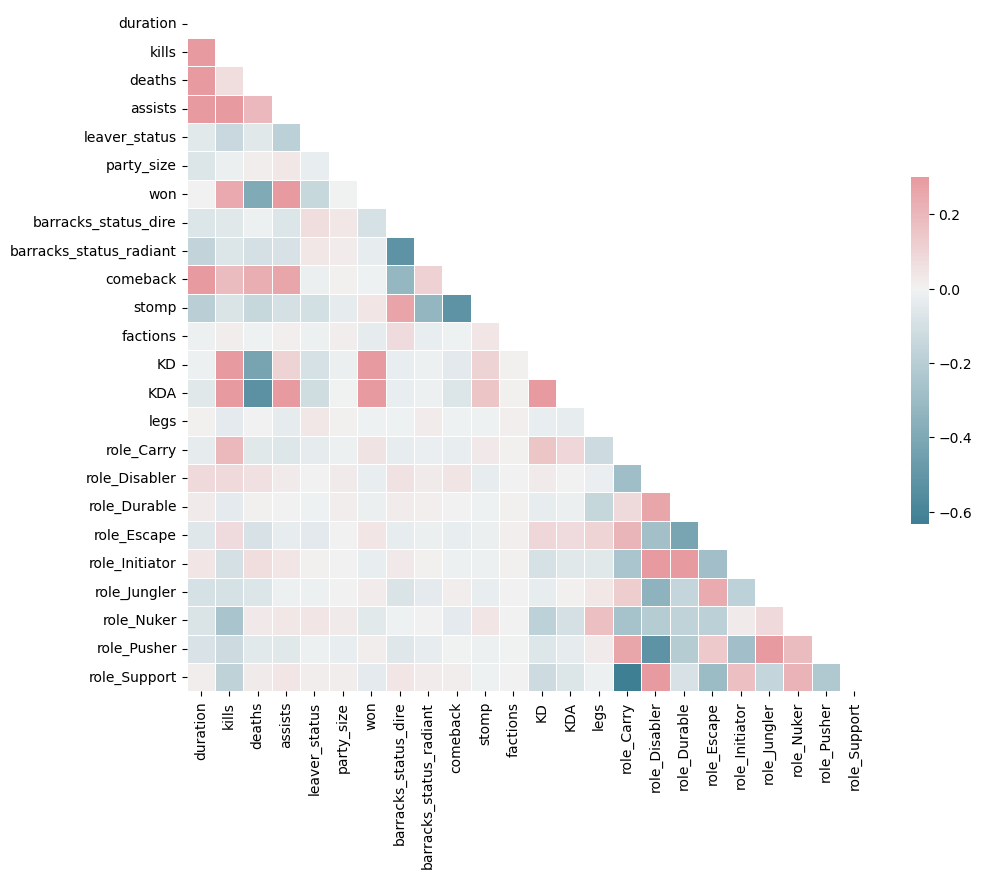

In [45]:
# Plot correlation heatmap for continuous variables
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df.corr(), dtype=bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt=".1g");

Nearly no correlation between duration and won, but as expacted between kills and won and even stronger a negative correlation between death and won. Roles are minimale correlated with kills but not with won. Faction seems to have no impact at all.

#### Win rate per patch

C:\Users\argv0\AppData\Local\Temp\ipykernel_14744\218513002.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_win.factions.replace(faction, inplace=True)


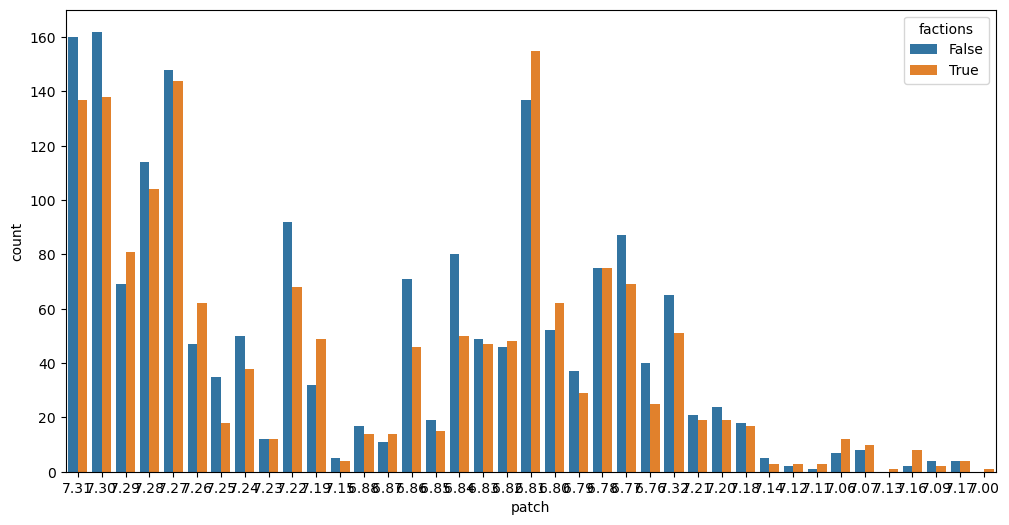

In [56]:
# Plot countplot of number of projects by year launched and "state"
df_win = df[df.won == True]

faction = {0: "Dire",
           1: "Radiant"}
df_win.factions.replace(faction, inplace=True)

plt.figure(figsize=(12,6))
sns.countplot(x="patch", hue="factions", data=df_win);

In [ ]:
Sortierung nach Patch. Wie Winrate

### scatterplot

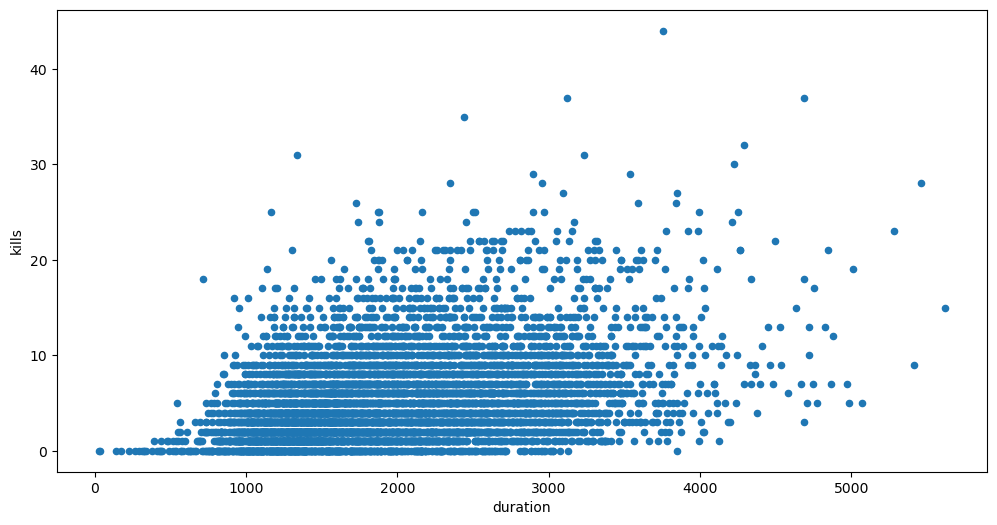

In [60]:
df.plot(kind='scatter', x='duration', y='kills', figsize=(12,6));

### Plot stripplot

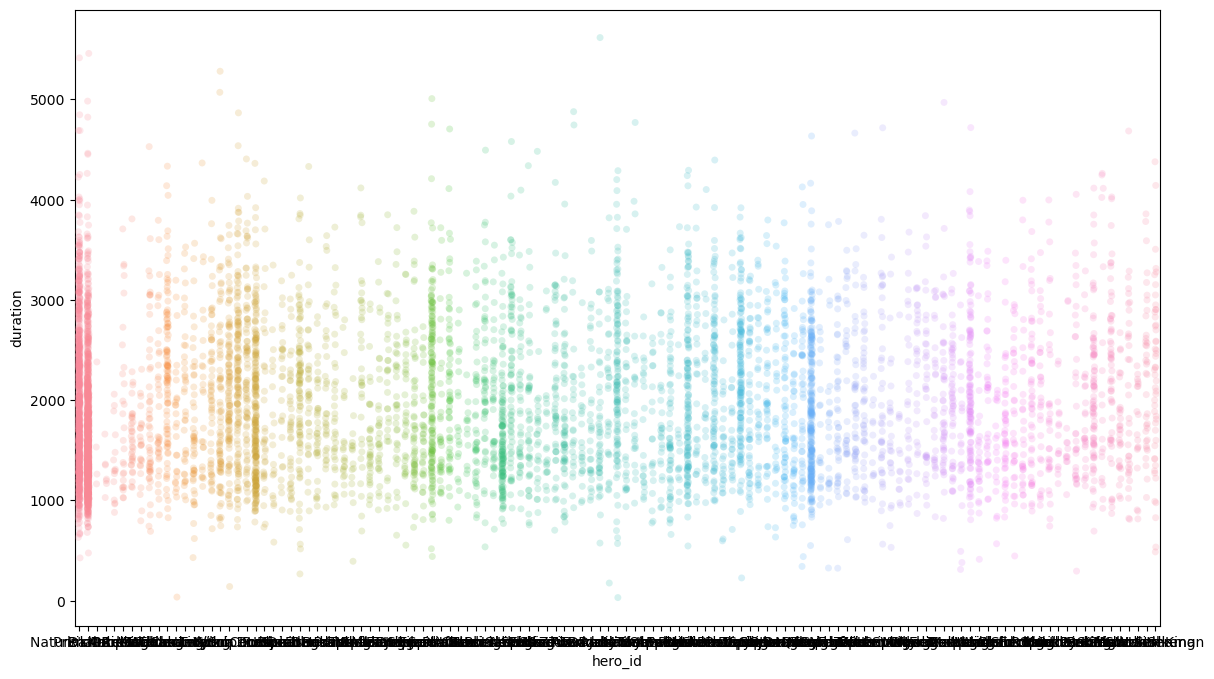

In [65]:
plt.figure(figsize=(14,8))
sns.stripplot(data=df,jitter=True,alpha=.2,
             x="hero_id",
             y="duration",size=5, dodge=True);